# Computing Meridional Overturning

In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mod = 'ESM4' # CM4, ESM4
exp = 'control' # control, antwater, stress, antwaterstress
mem = 251 # 251, 290, 332 (CM4) / 101, 151, 201 (ESM4)

rho0 = 1035.0
north = -30

In [4]:
outdir='/scratch/gpfs/jt7058/GFDL/fafmip/netcdf/'
rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/'
if mod=='CM4':
    subdir = 'CM4_piControl_C'
elif mod=='ESM4':
    subdir = 'ESM4_piControl_D'

pp = 'ocean_annual_rho2'
fafdir = '%s_faf%s_%s'%(subdir,exp,str(mem) if mod=='CM4' else str(mem))
full_path = os.path.join(rootdir,subdir,pp) if exp=='control' else os.path.join(rootdir,fafdir,pp)
print(full_path)

/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D/ocean_annual_rho2


In [5]:
ds = xr.open_mfdataset(full_path+'/'+pp+'.*.*.nc',use_cftime=True, 
                       drop_variables=['average_DT','average_T1','average_T2'])

In [6]:
print(ds.dims)

Frozen({'time': 200, 'nv': 2, 'rho2_i': 36, 'rho2_l': 35, 'yq': 576, 'xh': 720, 'yh': 576})


In [7]:
pp = 'ocean_monthly'

if subdir[:3] == 'CM4':
    grid = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
elif subdir[:3] == 'ESM':
    grid = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
else:
    print('grid is not available for '+subdir)

In [8]:
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])
# Control run is 100-year average
if exp=='control':
    # Years 281-380 for the CM4 control
    if mod=='CM4':
        ds = ds.sel(time=slice('0281','0380'))
        
    # Years 121-220 for the ESM4 control run
    elif mod=='ESM4':
        ds = ds.sel(time=slice('0121','0220'))

# Pertubation experiments are averaged over a 20 year period
else:
    # Years 51 to 70 for the CM4 pertubation experiments
    if mod=='CM4':
        ds = ds.sel(time=slice('0051','0070'))
        
    # Years 151-170 for the ESM4 pertubation experiment #101
    elif(mod=='ESM4') & (mem==101):
        ds = ds.sel(time=slice('0151','0170'))
    
    # Years 51 to 70 for the ESM4 pertubation experiment (other than 101)
    else:
        ds = ds.sel(time=slice('0051','0070'))
        
print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])

0101-07-02 to 0300-07-02
0121-07-02 to 0220-07-02


### Seperate by basin

In [9]:
from cmip_basins import generate_basin_codes

In [10]:
basincodes = generate_basin_codes(grid, lon='geolon_v', lat='geolat_v', mask='wet_v')

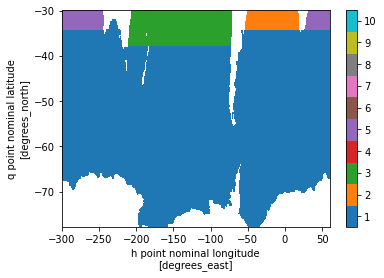

In [11]:
basincodes.where(grid['wet_v']==1).where(grid.geolat_v<north,drop=True)\
    .plot(cmap='tab10',vmin=0.5,vmax=10.5,cbar_kwargs={'ticks': np.arange(1,12,1)})

In [12]:
das = []

for idx in [2,3,5]:
    vmo = ds.vmo.where(basincodes==idx).where(grid['wet_v']==1)\
                .where(grid.geolat_v<north,drop=True).isel(yq=-1)   # ...drop=True).ffill('yq')... Why?
    vtrnsp = vmo.sum(dim='xh') / rho0 / 1.0e6
    das.append(vtrnsp)
    
da = xr.concat(das,pd.Index(['Atlantic', 'Pacific','Indian'], name='basin'))       

In [14]:
ddict_basin = {b:{} for b in ['Atlantic','Pacific','Indian']}
ddict_basin['Atlantic']['water_mass'] = ['Upper','SAMW','AAIW','NADW','AABW']
ddict_basin['Pacific']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']
ddict_basin['Indian']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']

ddict_basin['Atlantic']['sig2'] = [35.2,35.4,36.55,37.08]
ddict_basin['Pacific']['sig2'] = [35.3, 35.65, 36.45, 37.01]
ddict_basin['Indian']['sig2'] = [35.2, 35.7, 36.6, 37.01]

In [15]:
das = []
for idx, bname in enumerate(da.basin.values):
    print('\n',idx,bname)
    
    vtrsp = []
    for widx, wm in enumerate(ddict_basin[bname]['water_mass']):
        print(widx,wm)
        
        if widx ==0:
            print('Sum above',ddict_basin[bname]['sig2'][widx])
            vtrsp.append(da.sel(basin=bname)[:,da.rho2_l<ddict_basin[bname]['sig2'][widx]+1000].sum(dim='rho2_l'))
            
        elif widx < (len(ddict_basin[bname]['water_mass'])-1):
            print('Sum between',ddict_basin[bname]['sig2'][widx-1],'and',ddict_basin[bname]['sig2'][widx])
            vtrsp.append(da.sel(basin=bname)[:,(da.rho2_l>=ddict_basin[bname]['sig2'][widx-1]+1000)\
                                                &(da.rho2_l<ddict_basin[bname]['sig2'][widx]+1000)].sum(dim='rho2_l'))
            
        else:
            print('Sum below',ddict_basin[bname]['sig2'][widx-1])
            vtrsp.append(da.sel(basin=bname)[:,da.rho2_l>=ddict_basin[bname]['sig2'][widx-1]+1000].sum(dim='rho2_l'))
            
    das.append(xr.concat(vtrsp,pd.Index(['Upper','SAMW','AAIW','CDW','AABW'], name='water_mass')))


 0 Atlantic
0 Upper
Sum above 35.2
1 SAMW
Sum between 35.2 and 35.4
2 AAIW
Sum between 35.4 and 36.55
3 NADW
Sum between 36.55 and 37.08
4 AABW
Sum below 37.08

 1 Pacific
0 Upper
Sum above 35.3
1 SAMW
Sum between 35.3 and 35.65
2 AAIW
Sum between 35.65 and 36.45
3 CDW
Sum between 36.45 and 37.01
4 AABW
Sum below 37.01

 2 Indian
0 Upper
Sum above 35.2
1 SAMW
Sum between 35.2 and 35.7
2 AAIW
Sum between 35.7 and 36.6
3 CDW
Sum between 36.6 and 37.01
4 AABW
Sum below 37.01


In [16]:
vol_trsp = xr.concat(das,pd.Index(['Atlantic', 'Pacific','Indian'], name='basin')).reset_coords(drop=True)

In [17]:
with ProgressBar():
    vtrsp_NADW = vol_trsp.sel(water_mass='CDW',basin='Atlantic').load()
    vtrsp_CDWPac = vol_trsp.sel(water_mass='CDW',basin='Pacific').load()
    vtrsp_CDWInd = vol_trsp.sel(water_mass='CDW',basin='Indian').load()

[########################################] | 100% Completed | 16.7s
[########################################] | 100% Completed | 15.3s
[########################################] | 100% Completed | 14.2s


In [18]:
print('NADW:\n',str(np.round(vtrsp_NADW.mean('time').values,1))+' $\pm$ '+\
                str(np.round(vtrsp_NADW.std('time').values,1)))

NADW:
 -18.8 $\pm$ 0.8


In [19]:
print('CDW (Indo-Pacific):\n',str(np.round((vtrsp_CDWPac+vtrsp_CDWInd).mean('time').values,1))+' $\pm$ '+\
                              str(np.round((vtrsp_CDWPac+vtrsp_CDWInd).std('time').values,1)))

CDW (Indo-Pacific):
 -1.5 $\pm$ 2.1


In [20]:
print('Total CDW:\n',str(np.round((vtrsp_NADW+vtrsp_CDWPac+vtrsp_CDWInd).mean('time').values,1))+' $\pm$ '+\
                     str(np.round((vtrsp_NADW+vtrsp_CDWPac+vtrsp_CDWInd).std('time').values,1)))

Total CDW:
 -20.3 $\pm$ 2.3


### Mean transports

In [12]:
df = pd.DataFrame()

for idx in [2,3,5]:
    vmo = ds.vmo.where(basincodes==idx).where(grid['wet_v']==1)\
                .where(grid.geolat_v<north,drop=True).isel(yq=-1)   # ...drop=True).ffill('yq')... Why?
    vtrnsp = vmo.sum(dim='xh') / rho0 / 1.0e6
    vtrnsp_mean = vtrnsp.mean('time')
    df = pd.concat([df,vtrnsp_mean.reset_coords(drop=True).to_dataframe(str(idx))],sort=True,axis=1)
    
df.columns = ['Atlantic', 'Pacific','Indian']

In [13]:
head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))

In [14]:
fname = head+'_so_%sto%s_at%sS_mvt_rho2_basins.csv'\
        %(str(ds.time.dt.year[0].values).rjust(4, '0'),
          str(ds.time.dt.year[-1].values).rjust(4, '0'),
          str(abs(north)).replace('.',''))
print('Saving to file:', fname)

# Save with index column (time)
df.to_csv(outdir+fname, index=True)

Saving to file: CM4_antwater_251_so_0051to0070_at30S_mvt_rho2_basins.csv


In [15]:
df = pd.read_csv(outdir+'ESM4_control_so_0121to0220_at30S_mvt_rho2_basins.csv',index_col='rho2_l')

In [16]:
ddict_basin = {b:{} for b in ['Atlantic','Pacific','Indian']}
ddict_basin['Atlantic']['water_mass'] = ['Upper','SAMW','AAIW','NADW','AABW']
ddict_basin['Pacific']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']
ddict_basin['Indian']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']

ddict_basin['Atlantic']['sig2'] = [35.2,35.4, 36.55, 37.08]
ddict_basin['Pacific']['sig2'] = [35.3, 35.65, 36.45, 37.01]
ddict_basin['Indian']['sig2'] = [35.2, 35.7, 36.6, 37.01]

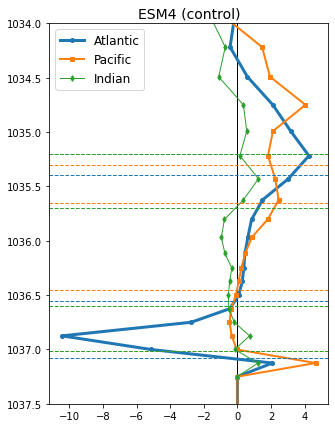

In [17]:
fig, ax = plt.subplots(figsize=(5,7))
ax.axvline(x=0, c = 'k', ls='-', lw=1)
ax.plot(df['Atlantic'],df.index,lw=3,marker='o',ms=4,label='Atlantic')
ax.plot(df['Pacific'],df.index,lw=2,marker='s',ms=4,label='Pacific')
ax.plot(df['Indian'],df.index,lw=1,marker='d',ms=4,label='Indian')
ax.set_ylim([1034,1037.5])
#ax.set_xlim([-2,2])
ax.invert_yaxis()
ax.legend(loc='upper left',fontsize=12)
ax.set_title('%s (%s)'%(mod,exp) if exp=='control' else '%s (%s-%s)'%(mod,exp,str(mem)),fontsize=14)

cidx = ['tab:blue','tab:orange','tab:green']
for idx, name in enumerate(ddict_basin):
    for sidx, sig in enumerate(ddict_basin[name]['sig2']):
        ax.axhline(y=sig+1000, c = cidx[idx], ls='--', lw=1)

plt.show()

In [23]:
ddict_basin = {b:{} for b in ['Atlantic','Pacific','Indian']}
ddict_basin['Atlantic']['water_mass'] = ['Upper','SAMW','AAIW','NADW','AABW']
ddict_basin['Pacific']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']
ddict_basin['Indian']['water_mass'] = ['Upper','SAMW','AAIW','CDW','AABW']

In [19]:
# ESM4 (control)
ddict_basin['Atlantic']['sig2'] = [35.2,35.4,36.55,37.08]
ddict_basin['Pacific']['sig2'] = [35.3, 35.65, 36.45, 37.01]
ddict_basin['Indian']['sig2'] = [35.2, 35.7, 36.6, 37.01]

ddict['CM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict['CM4']['sig2'] = [35.6, 36.1, 36.6, 37.06]
ddict['ESM4']['water_mass'] = ['Upper Ocean','SAMW','AAIW','CDW','AABW']
ddict['ESM4']['sig2'] = [35.2, 35.6, 36.5, 37.03]

In [24]:
ddict_basin['Atlantic']['sig2'] = [35.2, 35.6, 36.5, 37.03]
ddict_basin['Pacific']['sig2'] = [35.2, 35.6, 36.5, 37.03]
ddict_basin['Indian']['sig2'] = [35.2, 35.6, 36.5, 37.03]

In [25]:
for idx, (name, values) in enumerate(df.iteritems()):
    #print('\n',idx,name)
    
    vtrsp = []
    for widx, wm in enumerate(ddict_basin[name]['water_mass']):
        #print(widx,wm)
        
        if widx ==0:
            print('Sum above',ddict_basin[name]['sig2'][widx])
            vtrsp.append(df[df.index<ddict_basin[name]['sig2'][widx]+1000][name].sum())
        
        elif widx < (len(ddict_basin[name]['water_mass'])-1):
            print('Sum between',ddict_basin[name]['sig2'][widx-1],'and',
                  ddict_basin[name]['sig2'][widx])
            vtrsp.append(df[(df.index>=ddict_basin[name]['sig2'][widx-1]+1000)\
                       &(df.index<ddict_basin[name]['sig2'][widx]+1000)][name].sum())
            
        else:
            print('Sum below',ddict_basin[name]['sig2'][widx-1])
            vtrsp.append(df[df.index>=ddict_basin[name]['sig2'][widx-1]+1000][name].sum())
            
        #print(vtrsp)
    ddict_basin[name]['vol_trsp'] = vtrsp

Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03


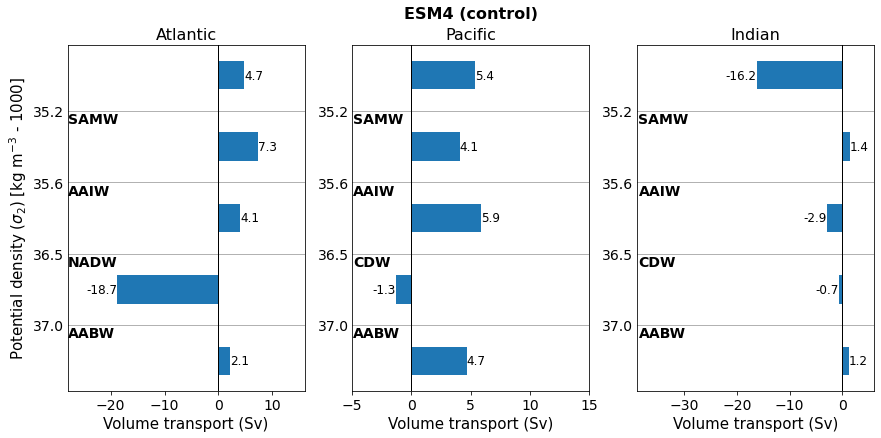

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(14,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2)
fig.suptitle('%s (%s)'%(mod,exp) if exp=='control' else '%s (%s-%s)'%(mod,exp,str(mem)),
             fontsize=16, fontweight='bold', y=0.99)


for idx, name in enumerate(ddict_basin):
    
    y = np.arange(len(ddict_basin[name]['water_mass'])) + 0.5
    x = ddict_basin[name]['vol_trsp']
    
    yloc = y
    
    axs[idx].axvline(x=0, c = 'k', ls='-', lw=1)
    p = axs[idx].barh(yloc,x,height=0.4 ,align='center',color='tab:blue')
    
    for i, bar in enumerate(p):
        val = bar.get_width()
        axs[idx].text(bar.get_width(), bar.get_y() + bar.get_height() / 2.0 , 
                      f'{val:.1f}', ha='right' if val<0 else 'left', va='center',color='k',fontsize=12)
    
    # Add subtitles and adjust xlimit
    if name=='Atlantic':
        axs[idx].set_title('Atlantic',fontsize=16)
        axs[idx].set_xlim([-28,16])
    elif name=='Pacific':
        axs[idx].set_title('Pacific',fontsize=16)
        axs[idx].set_xlim([-5,15])
    elif name=='Indian':
        axs[idx].set_title('Indian',fontsize=16)
        axs[idx].set_xlim([-39,6])
    
    # Add water mass names
    xlimit = axs[idx].get_xlim()
    for i, yline in enumerate(y[1:]-0.5):
        axs[idx].text(xlimit[0]+abs(xlimit[1]+xlimit[0])/100, yline+0.02, ddict_basin[name]['water_mass'][i+1], 
                      fontsize=14, fontweight='bold',ha='left', va='top')
        
    axs[idx].grid(True, 'major', 'y', ls='-', lw=1, c='k', alpha=.3)
    axs[idx].tick_params(axis='both', which='both', labelsize=14,
                         bottom=True, top=False, labelbottom=True,
                         left=False, right=False, labelleft=True)
    


    axs[idx].set_yticks(y[1:]-0.5)
    axs[idx].set_yticklabels([f'{val:.1f}' for val in ddict_basin[name]['sig2']])
    axs[idx].tick_params(axis='y', which='major', pad=0)
    
    axs[idx].invert_yaxis()
    axs[idx].set_xlabel('Volume transport (Sv)',fontsize=15)
    axs[0].set_ylabel(r'Potential density ($\sigma_2$) [kg m$^{-3}$ - 1000]',fontsize=15)

plt.show()

In [22]:
for mod in ['CM4', 'ESM4']:
    
    for exp in ['antwater', 'stress', 'antwaterstress']:
        for mem in (['251', '290', '332'] if mod=='CM4' else ['101', '151', '201']):
            if mod=='CM4':
                subdir = 'CM4_piControl_C'
            elif mod=='ESM4':
                subdir = 'ESM4_piControl_D'
                
            fafdir = '%s_faf%s_%s'%(subdir,exp,str(mem) if mod=='CM4' else str(mem))
            pp = 'ocean_annual_rho2'
            full_path = os.path.join(rootdir,subdir,pp) if exp=='control' else os.path.join(rootdir,fafdir,pp)
            head = '%s_%s'%(mod,exp) if exp=='control' else '%s_%s_%s'%(mod,exp,str(mem))
            print('\n'+head)
            print(full_path)
            ds = xr.open_mfdataset(full_path+'/'+pp+'.*.*.nc',use_cftime=True, 
                       drop_variables=['average_DT','average_T1','average_T2'])
            
            pp = 'ocean_monthly'
            if subdir[:3] == 'CM4':
                grid = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
            elif subdir[:3] == 'ESM':
                grid = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
            else:
                print('grid is not available for '+subdir)
                
            print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])
            
            if mod=='CM4':
                ds = ds.sel(time=slice('0051','0070'))
            # Years 151-170 for the ESM4 pertubation experiment #101
            elif(mod=='ESM4') & (mem=='101'):
                ds = ds.sel(time=slice('0151','0170'))
            # Years 51 to 70 for the ESM4 pertubation experiment (other than 101)
            else:
                ds = ds.sel(time=slice('0051','0070'))
            print(str(ds.time.values[0])[:10],'to',str(ds.time.values[-1])[:10])
            
            basincodes = generate_basin_codes(grid, lon='geolon_v', lat='geolat_v', mask='wet_v')
            df = pd.DataFrame()
            for idx in [2,3,5]:
                vmo = ds.vmo.where(basincodes==idx).where(grid['wet_v']==1)\
                        .where(grid.geolat_v<north,drop=True).isel(yq=-1)
                vtrnsp = vmo.sum(dim='xh') / rho0 / 1.0e6
                vtrnsp_mean = vtrnsp.mean('time')
                df = pd.concat([df,vtrnsp_mean.reset_coords(drop=True).to_dataframe(str(idx))],sort=True,axis=1)
            df.columns = ['Atlantic', 'Pacific','Indian']
            
            fname = head+'_so_%sto%s_at%sS_mvt_rho2_basins.csv'\
                        %(str(ds.time.dt.year[0].values).rjust(4, '0'),
                          str(ds.time.dt.year[-1].values).rjust(4, '0'),
                          str(abs(north)).replace('.',''))
            print('Saving to file:', fname)
            # Save with index column (time)
            df.to_csv(outdir+fname, index=True)


ESM4_antwater_101
/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafantwater_101/ocean_annual_rho2
0101-07-02 to 0175-07-02
0151-07-02 to 0170-07-02
Saving to file: ESM4_antwater_101_so_0151to0170_at30S_mvt_rho2_basins.csv

ESM4_antwater_151
/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafantwater_151/ocean_annual_rho2
0001-07-02 to 0100-07-02
0051-07-02 to 0070-07-02
Saving to file: ESM4_antwater_151_so_0051to0070_at30S_mvt_rho2_basins.csv

ESM4_antwater_201
/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafantwater_201/ocean_annual_rho2
0001-07-02 to 0100-07-02
0051-07-02 to 0070-07-02
Saving to file: ESM4_antwater_201_so_0051to0070_at30S_mvt_rho2_basins.csv

ESM4_stress_101
/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafstress_101/ocean_annual_rho2
0101-07-02 to 0185-07-02
0151-07-02 to 0170-07-02
Saving to file: ESM4_stress_101_so_0151to0170_at30S_mvt_rho2_basins.csv

ESM4_stress_151
/scratch/gpfs/jt7058/GFDL/fafmip/raw/ESM4_piControl_D_fafstress_1